## Project Title:
Telecom Customer Churn prediction model



## Introduction
This project aims to assist a telecom company in understanding their data and predicting customer churn. The company has provided access to three different datasets: the first dataset with 3000 records stored in a remote Microsoft SQL Server database, the second dataset with 2000 records stored on OneDrive, and the third dataset hosted on a GitHub repository.

## Objectives
Understand the data: Our first objective is to provide insights into the telecom company's data, including customer demographics, services availed, and payment details. This understanding will enable the company to make informed business decisions.

Find the lifetime value of each customer: By analyzing the data, we aim to identify factors that influence the rate at which customers churn. Understanding customer behavior and identifying key predictors will help the telecom company estimate the lifetime value of each customer.

Predict customer churn: The primary objective is to develop a predictive model that accurately determines whether a customer is likely to churn or not. We will employ machine learning algorithms such as logistic regression, decision trees, support vector machines, random forest, etc., to build a model that effectively predicts customer churn.

## Methodology
To achieve our objectives, we will follow the CRISP-DM framework, which consists of the following steps:

Data exploration: We will thoroughly explore the datasets to gain insights into the available variables, their distributions, and relationships. This step will provide us with an initial understanding of the data and help identify any data quality issues.

Missing value computations: We will identify missing values in the datasets and decide on an appropriate strategy for handling them. This may involve imputing missing values or removing data points with missing values.

Feature engineering: We will perform feature engineering to transform and create new variables that can potentially improve the predictive power of our models. This step may include encoding categorical variables, scaling numerical variables, or creating interaction terms.

Model development: We will utilize various machine learning algorithms such as logistic regression, decision trees, support vector machines, random forest, etc., to develop predictive models for customer churn. We will train the models on a subset of the data and evaluate their performance using appropriate metrics.

Model evaluation and interpretation: We will evaluate the trained models using evaluation metrics such as accuracy, precision, recall, and F1-score. Additionally, we will interpret the models to understand the factors driving customer churn and their relative importance.

Model optimization and hyperparameter tuning: We will fine-tune the models by optimizing their hyperparameters to improve their performance. This step may involve techniques like grid search or random search to find the optimal combination of hyperparameters.

By following this methodology, we aim to provide valuable insights to the telecom company and develop a reliable predictive model for customer churn.

In [1107]:
# %pip install pyodbc
# %pip install openpyxl
# %pip install imblearn
# %pip install xgboost
# %pip install python-dotenv

In [1175]:
# Data Handling
import pyodbc
from dotenv import dotenv_values
import numpy as np
import pandas as pd
import math
import requests
import io

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

# Statistical Analysis
from scipy.stats import chi2_contingency
from scipy.stats import randint
from scipy import stats

# Feature Processing
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler

# Machine Learning Models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Model Evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.model_selection import cross_val_score, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

# Other Packages
import random
import pickle
import warnings

warnings.filterwarnings("ignore")



## Data Loading
Loading first data from SQL

In [1109]:
# Load environment variables from .env file into a dictionary
environment_variables = dotenv_values('.env')
# Get the values for the credentials you set in the '.env' file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

In [1110]:
#creating a connection sring to the SQL  database
connection_string = f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password};MARS_Connection=yes;MinProtocolVersion=TLSv1.2;"

In [1111]:
#creating a connection
connection = pyodbc.connect(connection_string)

In [1112]:
# Read the excel file into a pandas dataframe
query = "Select * from dbo.LP2_Telco_churn_first_3000"
data1 = pd.read_sql(query, connection)

In [1113]:
# the first five rows of the first dataset
data1.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,False,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.850000,False
1,5575-GNVDE,Male,False,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.500000,False
2,3668-QPYBK,Male,False,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,False,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.750000,False
4,9237-HQITU,Female,False,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


In [1114]:
data1.to_csv('Data1.csv', index=False)


In [1115]:
#loading the second data set from GitHub repository
url = 'https://raw.github.com/Azubi-Africa/Career_Accelerator_LP2-Classifcation/main/LP2_Telco-churn-second-2000.csv'
download = requests.get(url).content
data2 = pd.read_csv(io.StringIO(download.decode('utf-8')))
data2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,5600-PDUJF,Male,0,No,No,6,Yes,No,DSL,No,...,No,Yes,No,No,Month-to-month,Yes,Credit card (automatic),49.50,312.7,No
1,8292-TYSPY,Male,0,No,No,19,Yes,No,DSL,No,...,Yes,Yes,No,No,Month-to-month,Yes,Credit card (automatic),55.00,1046.5,Yes
2,0567-XRHCU,Female,0,Yes,Yes,69,No,No phone service,DSL,Yes,...,Yes,No,No,Yes,Two year,Yes,Credit card (automatic),43.95,2960.1,No
3,1867-BDVFH,Male,0,Yes,Yes,11,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,74.35,834.2,Yes
4,2067-QYTCF,Female,0,Yes,No,64,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,111.15,6953.4,No


In [1116]:
data2.to_csv('Data2.csv', index=False)

## Loading data three from onedrive

In [1117]:
data3 = pd.read_excel('C:/Users/KEMUNTO/Downloads/Telco-churn-last-2000 (1).xlsx')
data3.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7613-LLQFO,Male,0,No,No,12,Yes,Yes,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Electronic check,84.45,1059.55
1,4568-TTZRT,Male,0,No,No,9,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.40,181.8
2,9513-DXHDA,Male,0,No,No,27,Yes,No,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,No,Electronic check,81.70,2212.55
3,2640-PMGFL,Male,0,No,Yes,27,Yes,Yes,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,79.50,2180.55
4,3801-HMYNL,Male,0,Yes,Yes,1,Yes,No,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,No,Mailed check,89.15,89.15


## Train dataset
The train dataset is the concated data of data1 and data2

In [1118]:
# Concat the two files into 1 dataset
train_data = pd.concat([data1, data2], axis=0, ignore_index=True)
train_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,True,False,1,False,None,DSL,False,...,False,False,False,False,Month-to-month,True,Electronic check,29.850000,29.85,False
1,5575-GNVDE,Male,0,False,False,34,True,False,DSL,True,...,True,False,False,False,One year,False,Mailed check,56.950001,1889.5,False
2,3668-QPYBK,Male,0,False,False,2,True,False,DSL,True,...,False,False,False,False,Month-to-month,True,Mailed check,53.849998,108.150002,True
3,7795-CFOCW,Male,0,False,False,45,False,None,DSL,True,...,True,True,False,False,One year,False,Bank transfer (automatic),42.299999,1840.75,False
4,9237-HQITU,Female,0,False,False,2,True,False,Fiber optic,False,...,False,False,False,False,Month-to-month,True,Electronic check,70.699997,151.649994,True


## Test dataset 

In [1119]:
# The Test dataset is the 3rd Dataset from one drive
Test_data = data3

## Hypothesis

Null hypothesis :

    1.There's a significant difference in the average monthly charges between churners and non-churners.


    Alternative hypothesis:

    1.There is no significant difference in the average monthly charges between churners and non-churners.
   
   ### Analytical questions
 
    1.What is the total churn rate?
    2.How does the different boolean attributes affect the churn?
    3.How does the different non-boolean attributes affect the churn?
    4.How does the different numerical attributes affect the churn?
    5. How does tenure affect the churn?
    6.How does the type of internet service affect churn?
    7.How does the type of contract affect the churn?
    8.How does the type of payment method affect the churn?

## EDA

In [1120]:
# Train Dataset Column information
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        5043 non-null   object 
 1   gender            5043 non-null   object 
 2   SeniorCitizen     5043 non-null   int64  
 3   Partner           5043 non-null   object 
 4   Dependents        5043 non-null   object 
 5   tenure            5043 non-null   int64  
 6   PhoneService      5043 non-null   object 
 7   MultipleLines     4774 non-null   object 
 8   InternetService   5043 non-null   object 
 9   OnlineSecurity    4392 non-null   object 
 10  OnlineBackup      4392 non-null   object 
 11  DeviceProtection  4392 non-null   object 
 12  TechSupport       4392 non-null   object 
 13  StreamingTV       4392 non-null   object 
 14  StreamingMovies   4392 non-null   object 
 15  Contract          5043 non-null   object 
 16  PaperlessBilling  5043 non-null   object 


In [1121]:
# Test Dataset Column information
Test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        2000 non-null   object 
 1   gender            2000 non-null   object 
 2   SeniorCitizen     2000 non-null   int64  
 3   Partner           2000 non-null   object 
 4   Dependents        2000 non-null   object 
 5   tenure            2000 non-null   int64  
 6   PhoneService      2000 non-null   object 
 7   MultipleLines     2000 non-null   object 
 8   InternetService   2000 non-null   object 
 9   OnlineSecurity    2000 non-null   object 
 10  OnlineBackup      2000 non-null   object 
 11  DeviceProtection  2000 non-null   object 
 12  TechSupport       2000 non-null   object 
 13  StreamingTV       2000 non-null   object 
 14  StreamingMovies   2000 non-null   object 
 15  Contract          2000 non-null   object 
 16  PaperlessBilling  2000 non-null   object 


## Observations from the datasets
The train dataset has 5043 rows (entries), while the test dataset has 2000 rows. Several columns in both datasets contain missing values.

The 'SeniorCitizens' column in the test dataset is an object while in the train dataset it is an integer.

The 'TotalCharges' column in each dataset represents the total charges for each customer which represents a numeric data type but it is presented as one with object (string) values.

As expected, the test dataset does not have the "Churn" column. This column is not needed because 'Churn' is the variable we want to predict. The goal is to use the trained model to predict whether customers in the test data will churn or not based on the other available features.

In [1122]:
# Transform the 'TotalCharges' column in the train dataset into a numeric data type
train_data['TotalCharges'] = pd.to_numeric(train_data['TotalCharges'], errors='coerce')

# Confirm the datatype
train_data['TotalCharges'].dtype

dtype('float64')

In [1123]:
# Transform the 'TotalCharges' column in the test dataset into a numeric data type
Test_data['TotalCharges'] = pd.to_numeric(Test_data['TotalCharges'], errors='coerce')

# Confirm the datatype
Test_data['TotalCharges'].dtype

dtype('float64')

In [1124]:
# checking unique values
# Exclude 'tenure', 'MonthlyCharges' and 'TotalCharges' 
for column in train_data.columns:
    if column not in ['customerID','tenure', 'MonthlyCharges', 'TotalCharges']:
        print('Column: {} - Unique Values: {}'.format(column, train_data[column].unique()))
        print('==='*15)

Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: [True False 'No' 'Yes']
Column: Dependents - Unique Values: [False True 'No' 'Yes']
Column: PhoneService - Unique Values: [False True 'Yes' 'No']
Column: MultipleLines - Unique Values: [None False True 'No' 'No phone service' 'Yes']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: [False True None 'No' 'Yes' 'No internet service']
Column: OnlineBackup - Unique Values: [True False None 'No' 'Yes' 'No internet service']
Column: DeviceProtection - Unique Values: [False True None 'No' 'Yes' 'No internet service']
Column: TechSupport - Unique Values: [False True None 'Yes' 'No' 'No internet service']
Column: StreamingTV - Unique Values: [False True None 'No' 'Yes' 'No internet service']
Column: StreamingMovies - Unique Values: [False True None 'No' 'Yes' 'No internet service']
Column: Contract - Unique Valu

In [1125]:
# Check unique values of each column in the test dataset using a for loop
for column in Test_data.columns:
    if column not in ['customerID','tenure', 'MonthlyCharges', 'TotalCharges']:
        print('Column: {} - Unique Values: {}'.format(column, Test_data[column].unique()))
        print('==='*15)

Column: gender - Unique Values: ['Male' 'Female']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['No' 'Yes']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: PhoneService - Unique Values: ['Yes' 'No']
Column: MultipleLines - Unique Values: ['Yes' 'No' 'No phone service']
Column: InternetService - Unique Values: ['Fiber optic' 'No' 'DSL']
Column: OnlineSecurity - Unique Values: ['No' 'No internet service' 'Yes']
Column: OnlineBackup - Unique Values: ['No' 'No internet service' 'Yes']
Column: DeviceProtection - Unique Values: ['No' 'No internet service' 'Yes']
Column: TechSupport - Unique Values: ['No' 'No internet service' 'Yes']
Column: StreamingTV - Unique Values: ['Yes' 'No internet service' 'No']
Column: StreamingMovies - Unique Values: ['No' 'No internet service' 'Yes']
Column: Contract - Unique Values: ['Month-to-month' 'One year' 'Two year']
Column: PaperlessBilling - Unique Values: ['Yes' 'No']
Column: PaymentMethod - Unique Values: ['Elec

## Cleaning data

In [1126]:
# Drop the customerID, gender, PhoneService, and MultipleLines columns from the train dataset
train_data.drop(columns=['customerID'], inplace=True)

train_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [1127]:
Test_data.drop(columns=['customerID'], inplace=True)

Test_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [1128]:
# Remove 'automatic' from payment method names in the train dataset
train_data['PaymentMethod'] = train_data['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

# Unique elements of the 'PaymentMethod' column after the modification 
train_data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer', 'Credit card'],
      dtype=object)

In [1129]:
# Remove 'automatic' from payment method names in the train dataset
Test_data['PaymentMethod'] = Test_data['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

# Unique elements of the 'PaymentMethod' column after the modification 
Test_data['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Credit card', 'Bank transfer'],
      dtype=object)

In [1130]:
# Modifying The 'SeniorCitizen' column
Test_data['SeniorCitizen'] = Test_data['SeniorCitizen'].replace({0: 'No', 1: 'Yes'})

# Modifying selected columns in the train and test datasets using a for loop
columns_to_modify = ['Partner', 'SeniorCitizen','Dependents', 'PhoneService', 'MultipleLines',
                          'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                          'StreamingTV', 'StreamingMovies', 'PaperlessBilling']

# Iterate over the columns to replace the unique values using a for loop
for column in columns_to_modify:
    # Replace boolean values with 'No' and 'Yes' in the train dataset
    train_data[column] = train_data[column].replace({False: 'No', True: 'Yes', 'No phone service': 'No'})
    # Replace boolean values with 'No' and 'Yes' in the test dataset
    Test_data[column] = Test_data[column].replace({False: 'No', True: 'Yes', 'No phone service': 'No'})

# Modifying The 'Churn' column
train_data['Churn'] = train_data['Churn'].replace({'No': False, None: False, 'Yes': True})

In [1131]:
# Check unique values of each column
for column in train_data.columns:
    if column not in ['tenure', 'MonthlyCharges', 'TotalCharges']:
        print('Column: {} - Unique Values: {}'.format(column, train_data[column].unique()))
        print('==='*15)

Column: gender - Unique Values: ['Female' 'Male']
Column: SeniorCitizen - Unique Values: [0 1]
Column: Partner - Unique Values: ['Yes' 'No']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: PhoneService - Unique Values: ['No' 'Yes']
Column: MultipleLines - Unique Values: [None 'No' 'Yes']
Column: InternetService - Unique Values: ['DSL' 'Fiber optic' 'No']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' None 'No internet service']
Column: OnlineBackup - Unique Values: ['Yes' 'No' None 'No internet service']
Column: DeviceProtection - Unique Values: ['No' 'Yes' None 'No internet service']
Column: TechSupport - Unique Values: ['No' 'Yes' None 'No internet service']
Column: StreamingTV - Unique Values: ['No' 'Yes' None 'No internet service']
Column: StreamingMovies - Unique Values: ['No' 'Yes' None 'No internet service']
Column: Contract - Unique Values: ['Month-to-month' 'One year' 'Two year']
Column: PaperlessBilling - Unique Values: ['Yes' 'No']
Column: PaymentMethod - Uniqu

In [1132]:
columns_to_encode = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                     'TechSupport', 'StreamingTV', 'StreamingMovies']

for column in columns_to_encode:
    train_data[column] = train_data[column].replace('No internet service', 'No')


In [1133]:
# Check unique values of each column
for column in Test_data.columns:
    if column not in ['tenure', 'MonthlyCharges', 'TotalCharges']:
        print('Column: {} - Unique Values: {}'.format(column, Test_data[column].unique()))
        print('==='*15)

Column: gender - Unique Values: ['Male' 'Female']
Column: SeniorCitizen - Unique Values: ['No' 'Yes']
Column: Partner - Unique Values: ['No' 'Yes']
Column: Dependents - Unique Values: ['No' 'Yes']
Column: PhoneService - Unique Values: ['Yes' 'No']
Column: MultipleLines - Unique Values: ['Yes' 'No']
Column: InternetService - Unique Values: ['Fiber optic' 'No' 'DSL']
Column: OnlineSecurity - Unique Values: ['No' 'No internet service' 'Yes']
Column: OnlineBackup - Unique Values: ['No' 'No internet service' 'Yes']
Column: DeviceProtection - Unique Values: ['No' 'No internet service' 'Yes']
Column: TechSupport - Unique Values: ['No' 'No internet service' 'Yes']
Column: StreamingTV - Unique Values: ['Yes' 'No internet service' 'No']
Column: StreamingMovies - Unique Values: ['No' 'No internet service' 'Yes']
Column: Contract - Unique Values: ['Month-to-month' 'One year' 'Two year']
Column: PaperlessBilling - Unique Values: ['Yes' 'No']
Column: PaymentMethod - Unique Values: ['Electronic check

In [1134]:
# Summary statistics of train_data to get insights into the distribution and basic characteristics of the numerical variables
train_data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,5043.000000,5043.000000,5043.000000,5035.000000
mean,0.162403,32.576641,65.090214,2302.062861
std,0.368857,24.529807,30.068133,2269.483576
min,0.000000,0.000000,18.400000,18.799999
25%,0.000000,9.000000,35.775000,417.675003
50%,0.000000,29.000000,70.550003,1401.150024
75%,0.000000,56.000000,90.050003,3862.000000
max,1.000000,72.000000,118.650002,8670.100000


In [1135]:
# Checking for missing values in the train dataset
train_data.isnull().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       269
InternetService       0
OnlineSecurity      651
OnlineBackup        651
DeviceProtection    651
TechSupport         651
StreamingTV         651
StreamingMovies     651
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          8
Churn                 0
dtype: int64

In [1136]:
# Drop observations with null values in 'TotalCharges' column from train dataset
train_data = train_data.dropna(subset=['TotalCharges'])

In [1137]:
# Drop observations with null values in 'TotalCharges' column from test dataset
test_data = Test_data.dropna(subset=['TotalCharges'])

In [1138]:
#Cleaning The "MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", and "StreamingMovies" Columns
columns_to_check = ["MultipleLines", "OnlineSecurity", "OnlineBackup",
                    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]

for column in columns_to_check:
    unique_values = train_data[column].unique()
    print('Column: {} - Unique Values: {}'.format(column, unique_values))
    print('==='*15)

Column: MultipleLines - Unique Values: [None 'No' 'Yes']
Column: OnlineSecurity - Unique Values: ['No' 'Yes' None]
Column: OnlineBackup - Unique Values: ['Yes' 'No' None]
Column: DeviceProtection - Unique Values: ['No' 'Yes' None]
Column: TechSupport - Unique Values: ['No' 'Yes' None]
Column: StreamingTV - Unique Values: ['No' 'Yes' None]
Column: StreamingMovies - Unique Values: ['No' 'Yes' None]


missing values in the columns above are denoted by none

In [1139]:
# Replace "None" with No
train_data.replace("None", "No", inplace=True)

# Check for missing values
missing_values = train_data.isnull().sum()

# Missing values in each column
missing_values

gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines       267
InternetService       0
OnlineSecurity      649
OnlineBackup        649
DeviceProtection    649
TechSupport         649
StreamingTV         649
StreamingMovies     649
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [1140]:
# Check for missing values
missing_values = Test_data.isnull().sum()

# Missing values in each column
missing_values

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        3
dtype: int64

In [1141]:
# checking duplicates
# Checking for duplicates in train dataset
train_duplicates = train_data.duplicated().sum()
train_duplicates

10

In [1142]:
# dropping the duplicates
train_data.drop_duplicates(keep='first', inplace=True)

In [1143]:
# Confirm if the duplicates in train_df have been dropped
Train_duplicates = train_data.duplicated().sum()
Train_duplicates

0

In [1144]:
# Checking for duplicates in test data
Test_duplicates = Test_data.duplicated().sum()
Test_duplicates

3

In [1145]:
# Drop the duplicates 
Test_data.drop_duplicates(keep='first', inplace=True)

In [1146]:
#Save the train dataset in a new CSV file to be used in PowerBI Visualization
train_data.to_csv('Trainz_Data.csv', index=False)
train_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,False
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,False
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,True
3,Male,0,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.299999,1840.750000,False
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,True


In [1147]:
# Map the 'Churn' column to numerical values
train_data['Churn'] = train_data['Churn'].replace({False: 0, True: 1})
train_data['Churn'].unique()

array([0, 1], dtype=int64)

In [1148]:
train_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1
3,Male,0,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.299999,1840.750000,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,1


In [1149]:
print(train_data.columns)

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


## Bivariate Analysis

## 1. Gender vs Churn

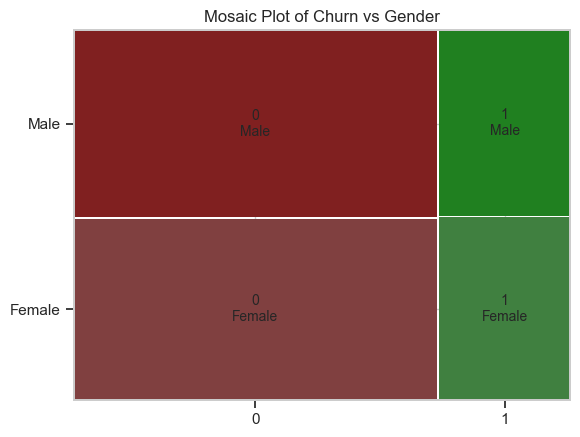

In [1150]:
mosaic(train_data, ['Churn', 'gender'], title='Mosaic Plot of Churn vs Gender')
plt.show()

The churn rate is slightly higher for male customers compared to female customers. This suggests that gender may have a minor influence on customer churn, but it is not a strong determining factor.

## 2. MonthlyCharges vs churn

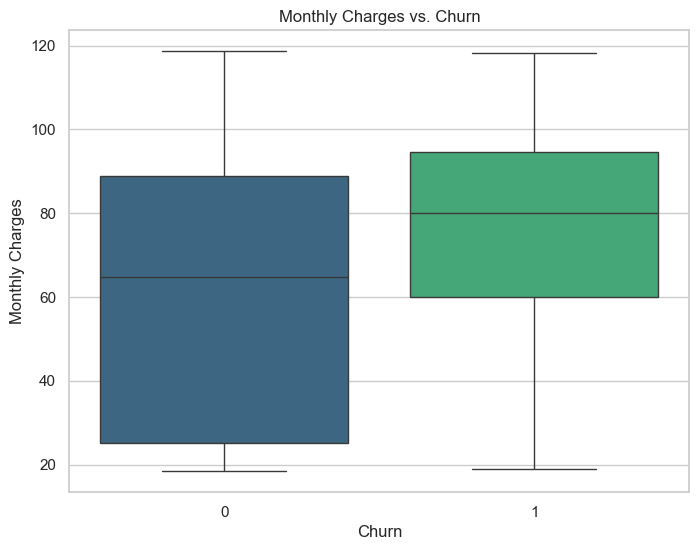

In [1151]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=train_data, palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges vs. Churn')
plt.show()

Churned customers tend to have higher monthly charges compared to non-churned customers.

## 3. Churn Vs Internetservice

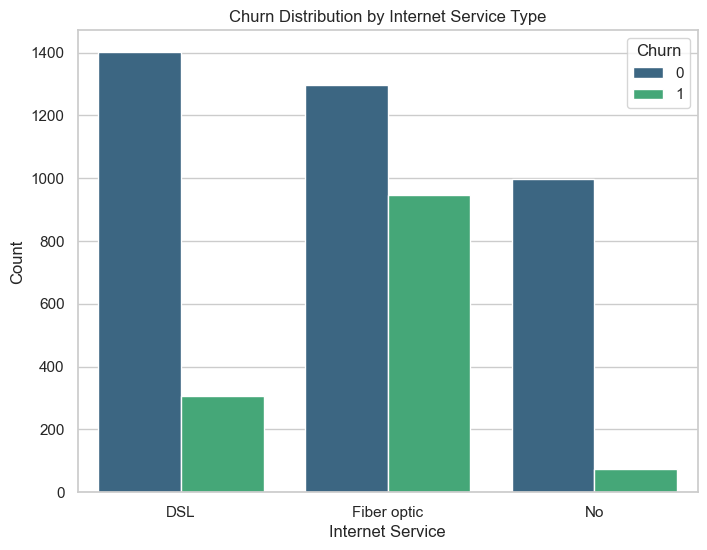

In [1152]:
plt.figure(figsize=(8, 6))
sns.countplot(x='InternetService', hue='Churn', data=train_data, palette='viridis')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.title('Churn Distribution by Internet Service Type')
plt.legend(title='Churn', loc='upper right')
plt.show()

Customers with fiber optic internet service have a higher churn rate compared to those with DSL or no internet service.

## 4.Churn vs Partner

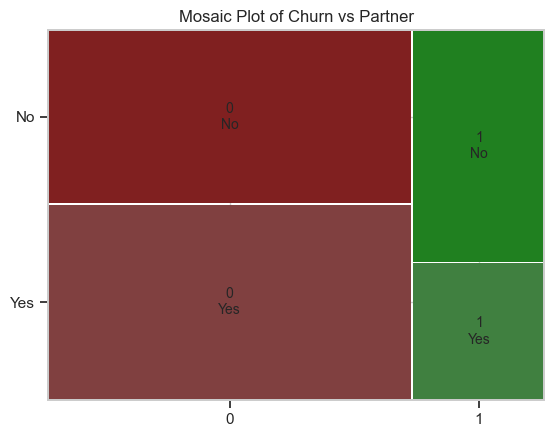

In [1153]:
mosaic(train_data, ['Churn', 'Partner'], title='Mosaic Plot of Churn vs Partner')
plt.show()

Customers with a partner churn less than customers with no partner.

## 5.Tenure vs Churn

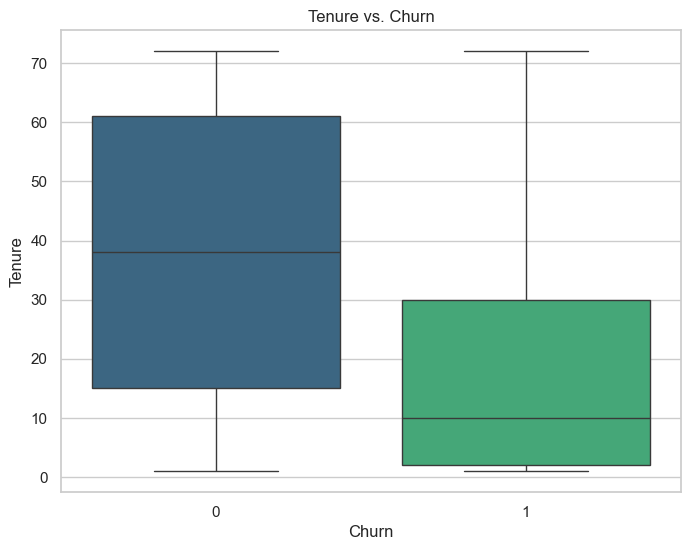

In [1154]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='Churn', y='tenure', data=train_data, palette='viridis')
plt.xlabel('Churn')
plt.ylabel('Tenure')
plt.title('Tenure vs. Churn')
plt.show()

Customers with lower tenure have a higher churn rate, while those with higher tenure are less likely to churn. There is an inverse relationship between tenure and churn rate.

## Multivariate Analysis

## 1.Relationship between Monthly Charges, Internet Service, and Churn

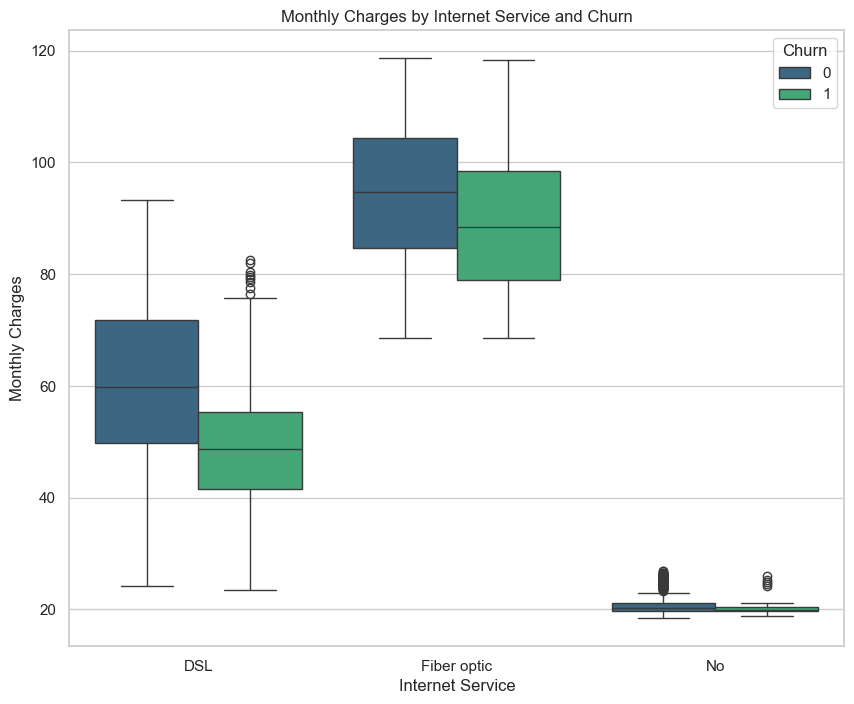

In [1155]:
# Create box plots for numerical features by churn
plt.figure(figsize=(10, 8))
sns.boxplot(x='InternetService', y='MonthlyCharges', hue='Churn', data=train_data, palette='viridis')
plt.xlabel('Internet Service')
plt.ylabel('Monthly Charges')
plt.title('Monthly Charges by Internet Service and Churn')
plt.show()

It can be observed that customers using fiber optic internet service generally have higher monthly charges compared to those using DSL. the boxplot highlights that churned customers, irrespective of the internet service type, tend to have higher monthly charges compared to non-churned customers. This suggests that customers with higher monthly charges may be more likely to churn, and this relationship may be more pronounced for fiber optic users.

## 2. Churn Rate by Contract Type and Payment Method

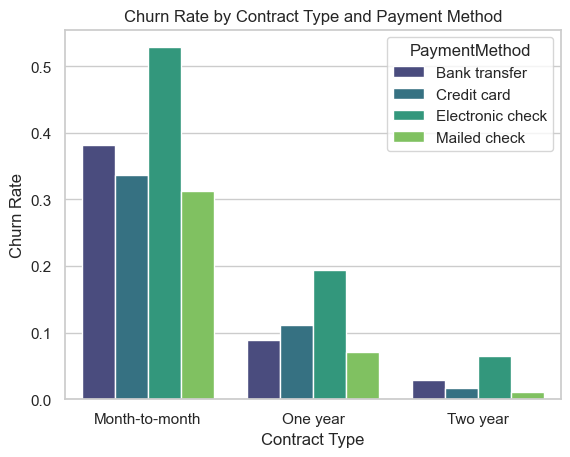

In [1156]:
churn_by_contract_payment = train_data.groupby(['Contract', 'PaymentMethod'])['Churn'].mean().reset_index()
sns.barplot(x='Contract', y='Churn', hue='PaymentMethod', data=churn_by_contract_payment, palette='viridis', orient='v')
plt.xlabel('Contract Type')
plt.ylabel('Churn Rate')
plt.title('Churn Rate by Contract Type and Payment Method')
plt.show()

The horizontal bar plot reveals that customers with month-to-month contracts have the highest churn rate, indicating a higher likelihood of churn compared to customers with one-year or two-year contracts. 

## Hypothesis Testing

In [1157]:
# Filter the dataset for churners and non-churners
churners = train_data[train_data['Churn'] == 'True']
non_churners = train_data[train_data['Churn'] =='False']

# Extract monthly charges for churners and non-churners
churner_monthly_charges = churners['MonthlyCharges']
non_churner_monthly_charges = non_churners['MonthlyCharges']

# Perform t-test for independent samples
t_statistic, p_value = stats.ttest_ind(churner_monthly_charges, non_churner_monthly_charges)

# Print the results
print("T-statistic:", t_statistic)
print("P-value:", p_value)

# Determine significance level
alpha = 0.05
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in average monthly charges between churners and non-churners.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in average monthly charges between churners and non-churners.")

T-statistic: nan
P-value: nan
Fail to reject null hypothesis: There is no significant difference in average monthly charges between churners and non-churners.


## Answering Questions

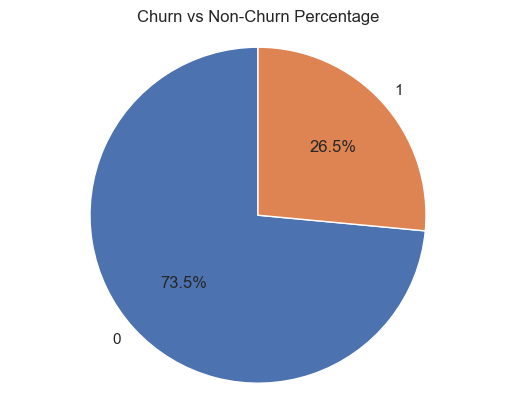

In [1158]:
## 1. What is the total churn rate
def calculate_churn_percentage(df, column_name):
    """
    Calculate the percentage of churn and non-churn in a specified column.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - column_name (str): The column name where churn data is stored.
    
    Returns:
    - dict: Dictionary containing the percentage of churn and non-churn.
    """
    # Calculate the frequency of each category in the specified column
    counts = df['Churn'].value_counts(normalize=True)
    
    # Convert the frequencies to percentage
    percentages = counts * 100
    
    return percentages

def plot_churn_pie_chart(percentages):
    """
    Plots a pie chart of churn and non-churn percentages.
    
    Parameters:
    - percentages (pd.Series): Series containing the percentages of churn and non-churn.
    """
    # Create a pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=percentages.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Title
    plt.title('Churn vs Non-Churn Percentage')

    # Show the plot
    plt.show()

df = pd.DataFrame(train_data)

# Calculate churn and non-churn percentages
churn_percentages = calculate_churn_percentage(df, 'Churn')

# Plot the pie chart
plot_churn_pie_chart(churn_percentages)

## 2. How does the different boolean attribute affect the churn

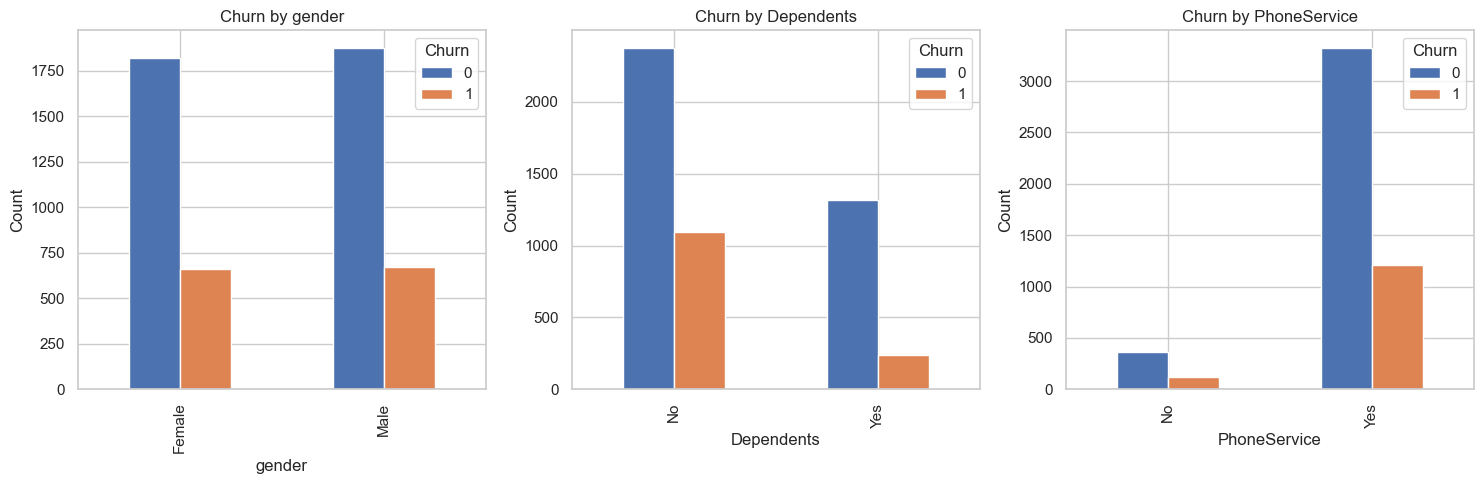

In [1159]:
# How does gender, partner and phone service affect churn
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for ax, feature in zip(axes, ['gender', 'Dependents', 'PhoneService']):
    df.groupby([feature, 'Churn']).size().unstack().plot(kind='bar', ax=ax, title=f'Churn by {feature}')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. How does the different non-boolean affect churn e.g Contract,PaymentMethod,

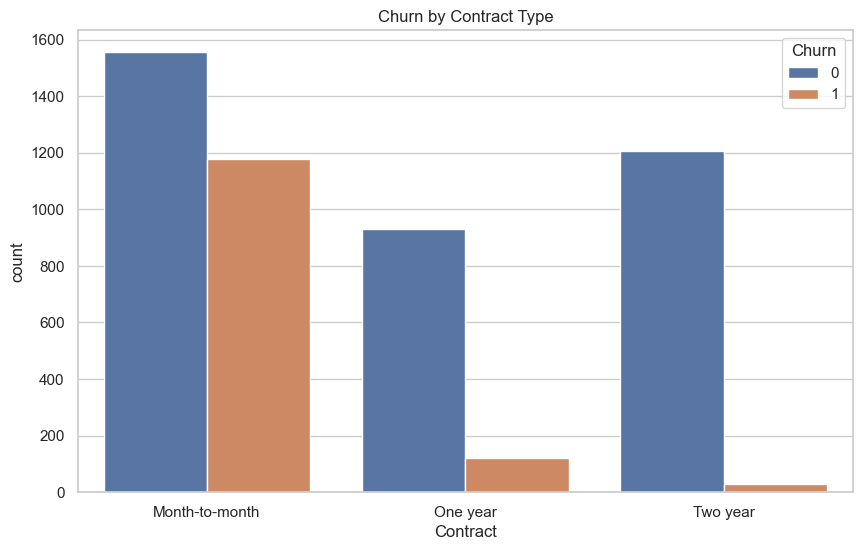

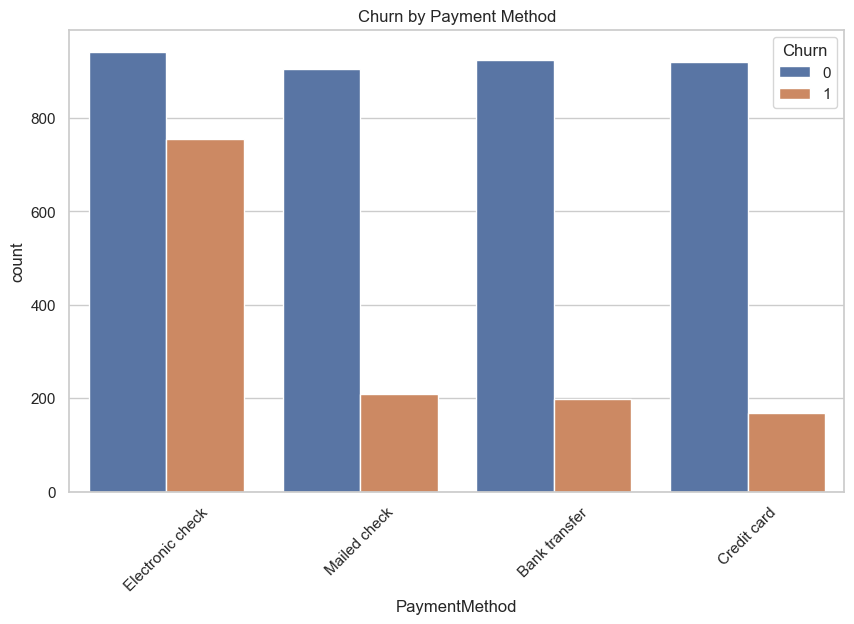

In [1160]:
# Setting up the visualization environment
sns.set(style="whitegrid")

# Bar plot for Contract vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='Contract', hue='Churn', data=train_data)
plt.title('Churn by Contract Type')
plt.show()

# Clustered bar plot for Payment Method vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='PaymentMethod', hue='Churn', data=train_data)
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.show()

## 4 How does monthly charges and total charges affect churn

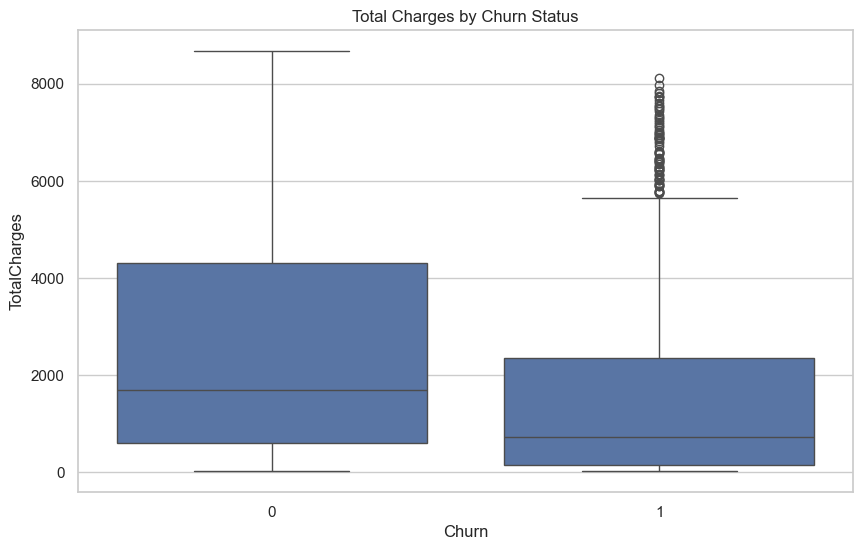

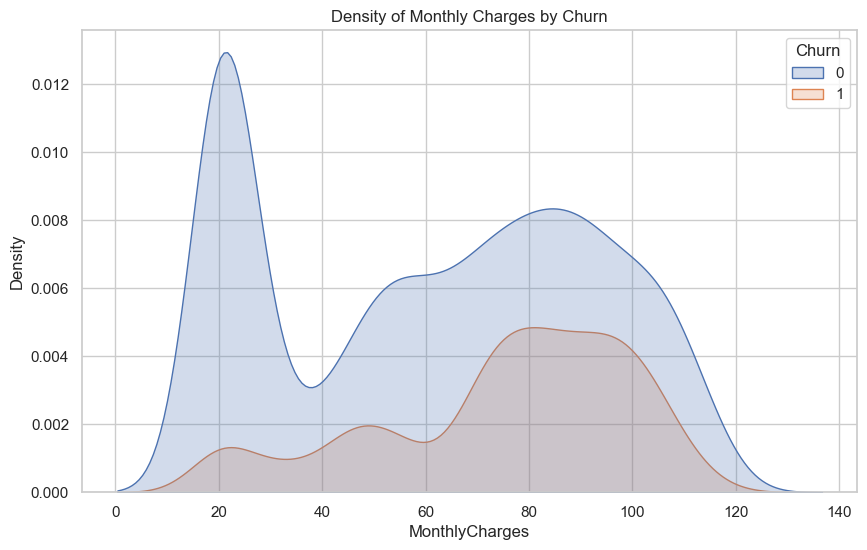

In [1161]:
# Setting up the visualization environment
sns.set(style="whitegrid")


# Box Plot for Total Charges by Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='TotalCharges', data=train_data)
plt.title('Total Charges by Churn Status')
plt.show()

# Density Plot for Monthly Charges by Churn
plt.figure(figsize=(10, 6))
sns.kdeplot(data=train_data, x='MonthlyCharges', hue='Churn', fill=True)
plt.title('Density of Monthly Charges by Churn')
plt.show()

## 5. How does the type of internet service affect the churn

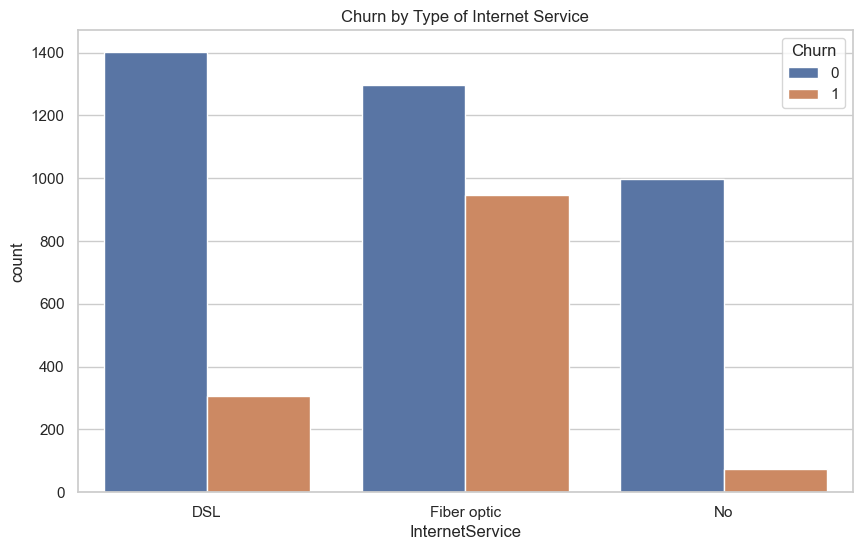

In [1162]:
# Count Plot for Internet Service vs Churn
plt.figure(figsize=(10, 6))
sns.countplot(x='InternetService', hue='Churn', data= train_data)
plt.title('Churn by Type of Internet Service')
plt.show()

In [1163]:
train_data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,None,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.850000,29.850000,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.950001,1889.500000,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.849998,108.150002,1
3,Male,0,No,No,45,No,None,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.299999,1840.750000,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.699997,151.649994,1


## Encoding categorical variables

In [1164]:
df = pd.DataFrame(train_data)

# Function to apply label encoding to specified features
def label_encoding(df, features):
    for i in features:
        df[i] = df[i].map({"Yes": 1, "No": 0})
    return df

# Apply label encoding to the specified feature list
feature_le = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
df = label_encoding(df, feature_le)

# Encode 'gender' separately
df["gender"] = df["gender"].map({"Female": 1, "Male": 0})

# Now df is correctly modified with all encodings applied
print(df)
train_data=df

      gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0          1              0        1           0       1             0   
1          0              0        0           0      34             1   
2          0              0        0           0       2             1   
3          0              0        0           0      45             0   
4          1              0        0           0       2             1   
...      ...            ...      ...         ...     ...           ...   
5038       0              0        1           1      24             1   
5039       1              0        1           1      72             1   
5040       1              0        1           1      11             0   
5041       0              1        1           0       4             1   
5042       0              0        0           0      66             1   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
0             None             DSL           

In [1165]:
features_ohe = ["MultipleLines","InternetService","OnlineSecurity","OnlineBackup",
                "DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaymentMethod"]
df_ohe = pd.get_dummies(train_data, columns=features_ohe)

In [1166]:
features_mms = ["tenure","MonthlyCharges","TotalCharges"]

df_mms = pd.DataFrame(df_ohe, columns=features_mms)
df_remaining = df_ohe.drop(columns=features_mms)

mms = MinMaxScaler(feature_range=(0,1))
rescaled_feature = mms.fit_transform(df_mms)

rescaled_feature_df = pd.DataFrame(rescaled_feature, columns=features_mms, index=df_remaining.index)
df = pd.concat([rescaled_feature_df,df_remaining],axis=1)

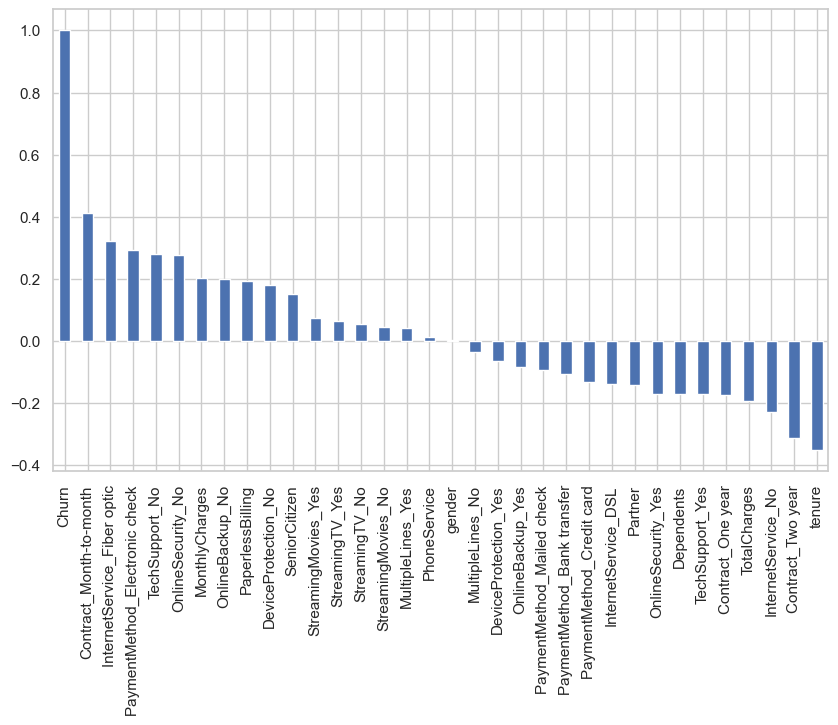

In [1167]:
plt.figure(figsize=(10,6))
df.corr()["Churn"].sort_values(ascending=False).plot(kind="bar")
plt.savefig("correlation.png", dpi=300)
plt.show()

In [1168]:
X = df.drop(columns = "Churn")
y = df.Churn

X_train,X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4020, 33), (1005, 33), (4020,), (1005,))

In [1169]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
y_pred_knn_proba = knn.predict_proba(X_test)